<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/FINAL%20_FILES/Fashion_MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import and pre-process the data, train the VAE

**Import libraries used and mount a google drive**

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
tf.autograph.set_verbosity(0)
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**Function to plot images**

Takes images and labels datasets and plots certain images from it 

In [0]:
def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((len(figures_to_plot))/10)
    plot = plt.figure(figsize=[20,20*n_rows])
    for n, i in enumerate(figures_to_plot):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,n+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

Create a dataset from images

pick_class = selects all the data of certain classes

set_pixels_binary = scales the input values within 0 and 1

cut_data = selects a certain amount of data only

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    return images

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(len(y_train)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(len(y_test)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

**Class of the Variational Autoencoder Models (two different models given, choose one)**

encode = takes an image and returns the mean and the log(variance) of its latent vector 

reparameterize = takes the mean and log(variance) of a latent vector and samples a vector from them

decode = takes a latent vector and returns the reconstruction of x

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

**Function to compute the ELBO loss**

Takes an image and returns the ELBO loss. The term variance is a hyperparameter and can be changed

In [0]:
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO, logpx_z, KL #Negative because we want to maximise it

**Define optimizer and loss metrics**

The learnign rate of the Adam optimizer is a hyperparameter

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Define a function for a train and test step**

train_step = updated the model using the optimizer and the gradients of the loss function; updates the train_loss metric

test_step = calculates the loss function of the test image; updates the test_loss metric

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss,_,_ = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss,_,_ = calculate_ELBO(model, x)
    test_loss(loss)

**Write function to train the dataset**

takes train and test datasets and trains the train dataset for a number of epochs

plots the ELBO value of the train and test dataset for each epoch

generates images obtained from a random latent vector (sampled form a normal distribution)

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, range(plots_per_epoch))
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

**Change the amount of data from each class (if desired)**

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        x_class, y_class = pick_class(x, y, [chosen_classes[i]])
        x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)
chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [5, 10, 50, 100, 500, 1000, 2000, 3000, 4500, 6000]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

**Create and train 10 different Variational Autoencoders**

Each VAE is trained with the images of a class

Data with very few training images will require more epochs

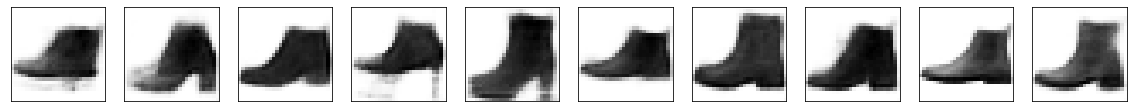

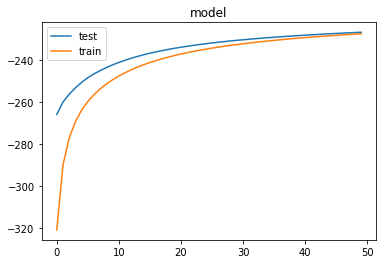

In [16]:
x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0])
x_train_1, y_train_1, x_test_1, y_test_1, train_dataset_1, test_dataset_1 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[1])
x_train_2, y_train_2, x_test_2, y_test_2, train_dataset_2, test_dataset_2 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[2])
x_train_3, y_train_3, x_test_3, y_test_3, train_dataset_3, test_dataset_3 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[3])
x_train_4, y_train_4, x_test_4, y_test_4, train_dataset_4, test_dataset_4 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[4])
x_train_5, y_train_5, x_test_5, y_test_5, train_dataset_5, test_dataset_5 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[5])
x_train_6, y_train_6, x_test_6, y_test_6, train_dataset_6, test_dataset_6 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[6])
x_train_7, y_train_7, x_test_7, y_test_7, train_dataset_7, test_dataset_7 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[7])
x_train_8, y_train_8, x_test_8, y_test_8, train_dataset_8, test_dataset_8 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[8])
x_train_9, y_train_9, x_test_9, y_test_9, train_dataset_9, test_dataset_9 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[9])

z_size = 100
model_0 = CVAE(z_size)
model_1 = CVAE(z_size)
model_2 = CVAE(z_size)
model_3 = CVAE(z_size)
model_4 = CVAE(z_size)
model_5 = CVAE(z_size)
model_6 = CVAE(z_size)
model_7 = CVAE(z_size)
model_8 = CVAE(z_size)
model_9 = CVAE(z_size)

model_dict = {'0' : model_0,
              '1' : model_1,
		      '2' : model_2,
              '3' : model_3,
              '4' : model_4,
              '5' : model_5,
              '6' : model_6,
              '7' : model_7,
              '8' : model_8,
              '9' : model_9}

train_test_dataset(model_0, train_dataset_0, test_dataset_0, 160, generate=True)
train_test_dataset(model_1, train_dataset_1, test_dataset_1, 130, generate=True)
train_test_dataset(model_2, train_dataset_2, test_dataset_2, 110, generate=True)
train_test_dataset(model_3, train_dataset_3, test_dataset_3, 90, generate=True)
train_test_dataset(model_4, train_dataset_4, test_dataset_4, 70, generate=True)
train_test_dataset(model_5, train_dataset_5, test_dataset_5, 50, generate=True)
train_test_dataset(model_6, train_dataset_6, test_dataset_6, 50, generate=True)
train_test_dataset(model_7, train_dataset_7, test_dataset_7, 50, generate=True)
train_test_dataset(model_8, train_dataset_8, test_dataset_8, 50, generate=True)
train_test_dataset(model_9, train_dataset_9, test_dataset_9, 50, generate=True)

**Check reconstruction performance**

Select a range of image to reconstruct, the ELBO loss is displayed under each reconstruction

Original Pictures:


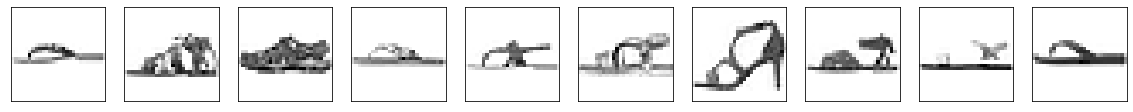

Reconstructed Pictures, with ELBO loss:


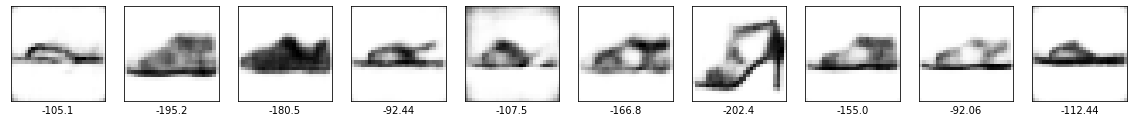

In [17]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images/input_range
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i],_,_ = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=range(images_n), include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=range(images_n), include_labels=True)

reconstruct_images(model_5, x_test_5[0:10])

**Visualize the latent space**

select a range (range1 to range2) of the train/test data for which to plot the latent vector values of 2 dimensions (a and b)

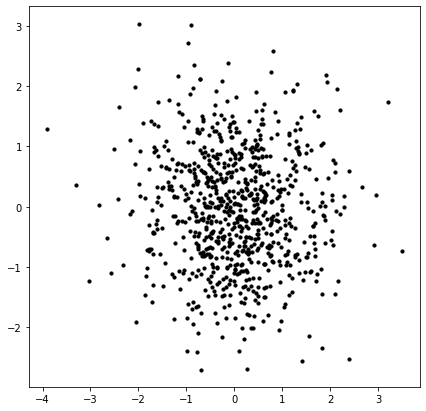

In [18]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize/input_range
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
      
    if data_y[i] == 0:
      color = 'blue'
    if data_y[i] == 1:
      color = 'orange'
    if data_y[i] == 2:
      color = 'green'
    if data_y[i] == 3:
      color = 'red'
    if data_y[i] == 4:
      color = 'purple'  
    if data_y[i] == 5:
      color = 'brown'
    if data_y[i] == 6:
      color = 'pink'
    if data_y[i] == 7:
      color = 'gray'
    if data_y[i] == 8:
      color = 'black'
    if data_y[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)


visualize_latent_space(model_8, 0,800, x_test_8, y_test_8, 0,1)

**Check reconstruction performance**

Check the average loss the models obtain for each class

Create confusion matrix table with all the losses

Model trained with class 0


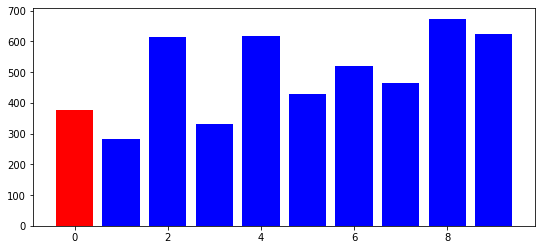

Model trained with class 1


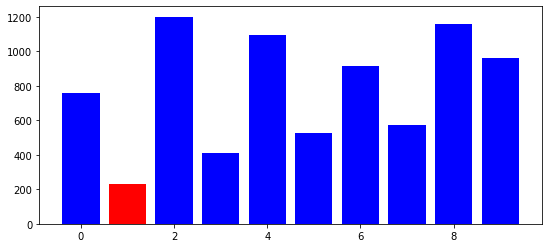

Model trained with class 2


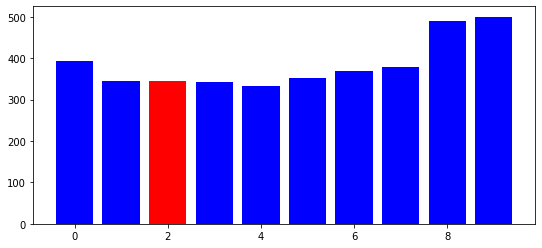

Model trained with class 3


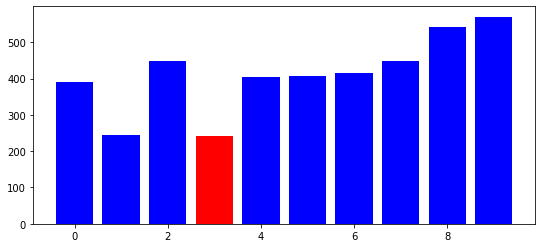

Model trained with class 4


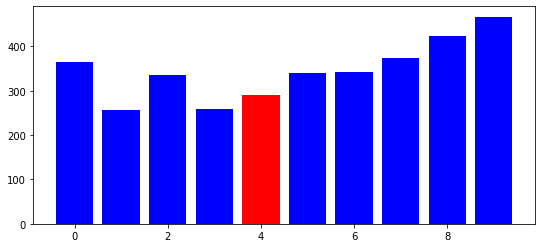

Model trained with class 5


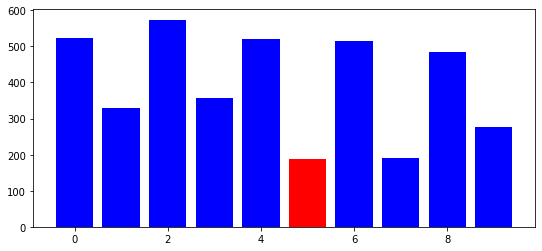

Model trained with class 6


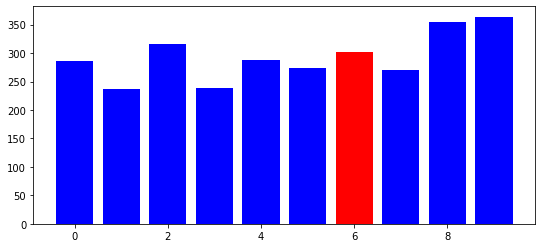

Model trained with class 7


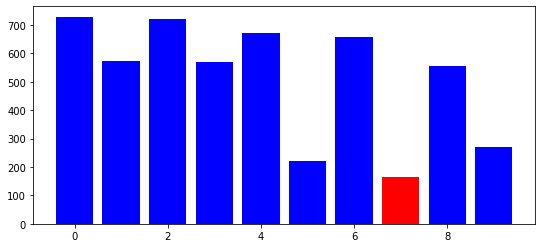

Model trained with class 8


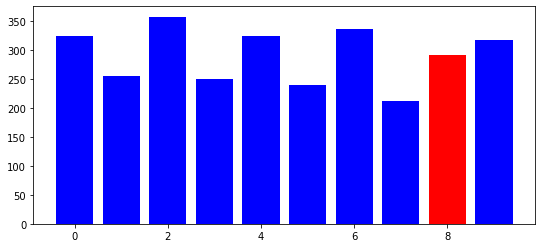

Model trained with class 9


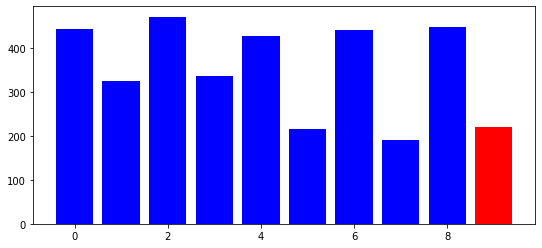

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9
Class 0,375.46,760.85,392.78,389.81,364.50,522.52,285.45,729.17,324.49,443.31
Class 1,283.63,229.56,345.31,244.21,257.00,329.25,236.76,573.87,255.67,325.54
Class 2,615.25,1200.90,345.53,448.55,335.26,573.89,316.76,721.69,357.08,471.07
Class 3,330.08,412.82,341.95,241.57,259.26,357.93,238.05,571.42,250.44,336.98
Class 4,617.16,1095.75,332.44,404.14,289.54,519.07,287.20,672.39,323.10,426.35
Class 5,429.09,524.14,353.26,406.34,340.72,187.67,273.22,220.46,240.13,216.41
Class 6,518.83,917.67,368.15,414.60,342.72,516.25,302.71,659.34,336.46,441.80
Class 7,464.49,575.71,379.74,449.36,374.00,190.47,270.52,163.30,212.08,190.08
Class 8,673.56,1157.39,489.07,541.94,423.11,483.81,353.82,555.63,290.39,448.26
Class 9,623.11,963.53,500.17,570.36,466.94,275.21,363.91,269.30,316.68,219.94


In [20]:
table_of_losses = np.zeros([N_class, N_class])
for i in range(0,N_class):
  model = model_dict[str(i)]
  print('Model trained with class {}'.format(i))
  plt.figure(figsize=[9,4])
  for j in range(N_class):
    test_images = x_test[(y_test==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    loss,_,_ = calculate_ELBO(model,test_images)
    table_of_losses[j,i] = loss
    if j==i:
      color='red'
    else:
      color='blue'
    plt.bar(j,loss.numpy(),color=color)
  plt.show()

 
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(table_of_losses, decimals=2), index=index, columns=columns)
table_loss

#### Classify test images

**Calculate the loss vectors for each image (train and test data)**

In [0]:
def compute_losses(x):
  losses_per_image = np.zeros([len(x),10])
  for i in range(len(x)):
    if not i%10:
      clear_output()
      print('Progress:{}%'.format(100*(i+1)/len(x)))
    image = x[i]/input_range
    image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    for j in range(0,10):
      model = model_dict[str(j)]
      loss,_,_ = calculate_ELBO(model,image)
      losses_per_image[i,j]= loss
  return losses_per_image

In [24]:
losses_per_image_test = compute_losses(x_test)
losses_per_image_train = compute_losses(x_train)

Progress:99.97669676667638%


**Input the loss vectors through a softma function to obtain a probability distribution**

Each entry in the vector represents the probability of the image to belong to that class

In [0]:
def losses_softmax(x):
  x_normalized = np.zeros(np.shape(x))
  softmax_probabilities = np.zeros(np.shape(x))
  for i in range(len(x)):
    x_normalized[i,:] = x[i,:]/np.min(x[i,:])
    x_normalized[i,:] = np.multiply(x_normalized[i,:],-2)
    e_x = np.exp(x_normalized)
    softmax_probabilities[i,:] = (np.exp(x_normalized[i,:]) / np.exp(x_normalized[i,:]).sum())*100
  return softmax_probabilities

In [0]:
softmax_probabilities_test = losses_softmax(losses_per_image_test)
softmax_probabilities_train = losses_softmax(losses_per_image_train)

##### Classify using highest softmax probability (method 1)

**Classify an image as the class that has the highest probability**

In [0]:
def classify_highest_softmax(x):
  predicted_class = np.zeros([len(x)],)
  for i in range(len(x)):
    predicted_class[i] = np.argmax(x[i,:])
  return predicted_class

In [0]:
predicted_class_1 = classify_highest_softmax(softmax_probabilities_test)

##### Classify using ROC curves (method 2)

**Write function to calculate the optimal thresholds for each class**

Finds the best probability threshold to classify a class individually (either that class or not)

In [0]:
def ROC_thresholds(y, prob_x, plot_ROC_curves=1):
  y_true = np.zeros([10,len(y)])
  for i in range(len(y)):
    y_true[y[i].astype('int'),i]=1 #each row has all the images, each row is a class. Values are 1 where the image corresponds to that class

  y_score = np.zeros([10,len(y)])
  for i in range(len(y)):
    y_score[:,i] = prob_x[i] #each column is the softmax distribution for each image

  optimal_thresholds = np.zeros([10,])
  for i in range(10):
    fpr, tpr, threshold = roc_curve(y_true[i,:], y_score[i,:])
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    optimal_threshold = threshold[optimal_idx]
    optimal_thresholds[i] = optimal_threshold
    if plot_ROC_curves == 1:
      plot = plt.figure()
      plt.plot(fpr, tpr, color='red')
      plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC curve for class '+str(i))
      plt.show()
  return optimal_thresholds

**Find optimal thresholds for each class**

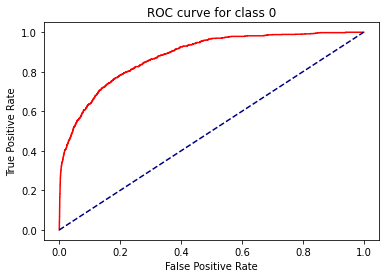

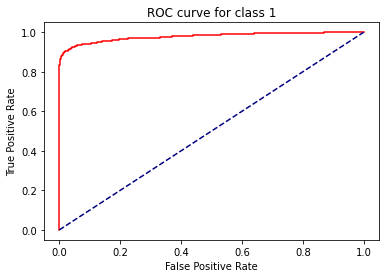

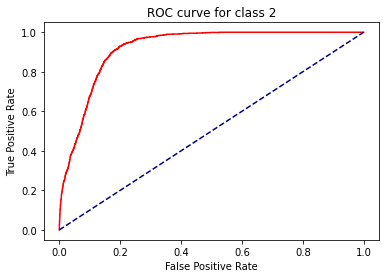

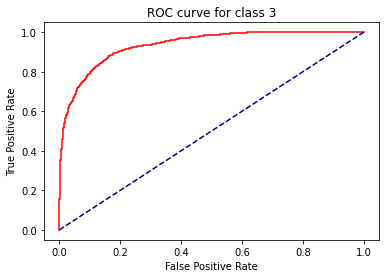

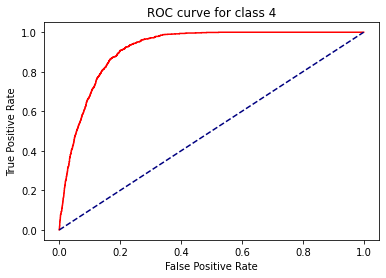

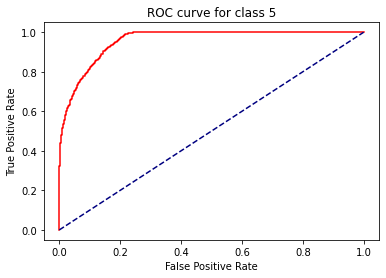

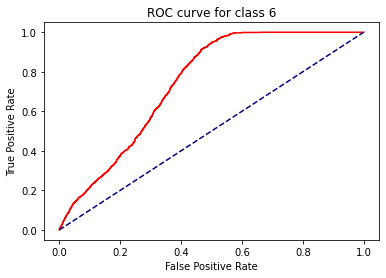

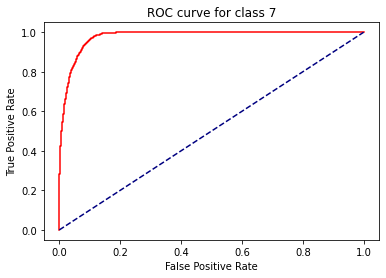

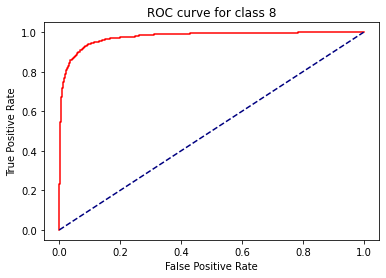

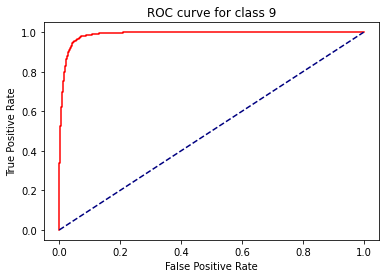

In [31]:
optimal_thresholds = ROC_thresholds(y_test, softmax_probabilities_test, 1)

**Classify the images using the ROC method**

Classify images as the class whose probability is the furthest away from the optimal threshold

In [0]:
def classify_ROC_thresholds(prob_x, thresholds, y):
  predicted_class = np.zeros([len(y),])
  for i in range(len(y)):
    diff = prob_x[i,:]/thresholds
    predicted_class[i]=np.argmax(diff)
  return predicted_class

In [0]:
predicted_class_2 = classify_ROC_thresholds(softmax_probabilities_test, optimal_thresholds, y_test)

##### Classify using a NN classifier (method 3)

**Create model**

In [0]:
from sklearn.utils import class_weight

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(128, activation = 'relu')
    self.d2 = tf.keras.layers.Dense(128, activation= 'relu')
    self.d3 = tf.keras.layers.Dense(10)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return x

model = MyModel()

**Define optimizer and metrics**

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00003)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Write loss function**

Weighted cross entropy with weights inversely proportional to the amount of data in each class

In [0]:
def calculate_loss(model, x1, y):
    pred = model(x1)
    labels = y

    w = np.array([343/343, 171/343, 34/343, 17/343, 4/343, 1.7/343, 0.9/343, 0.6/343, 0.4/343, 0.3/343])
    w = (np.max(labels*w,axis=1)) 

    loss = tf.nn.softmax_cross_entropy_with_logits(labels, pred)
    loss = loss*w
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
def train_step(model, x1, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x1, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x1, y, optimizer):
    loss = calculate_loss(model, x1)
    test_loss(loss)

def train_only_dataset(model, train_dataset1, epochs):  
  for epoch in range(epochs):
    for data1 in train_dataset1:
      train_x1 = data1[0]
      train_y = data1[1]
      train_step(model, train_x1, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

**Function to create a dataset from images**

setup_dataset shuffles the images

setup_dataset_no_shuffle doesn't shuffle the images

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

**Train the classifier**

99.15---> 0.0012429873


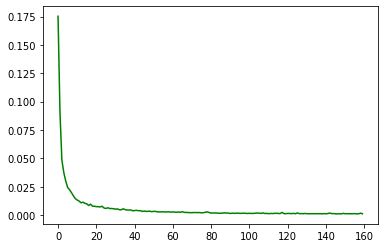

TRAINING TIME = 141.32899475097656



In [42]:
from sklearn.utils import shuffle

start_time = time.time()

losses = []

losses_test = []
test_data = losses_per_image_test
test_labels = tf.one_hot(y_test, 10)

epochs = 100

for j in range(epochs):
  losses_per_image_train, y_train = shuffle(losses_per_image_train, y_train)

  for i in range(16):
    dataset1 = setup_dataset_no_shuffle(losses_per_image_train[1000*i:1000*(i+1)], tf.one_hot(y_train[1000*i:1000*(i+1)],10))
    loss = train_only_dataset(model, dataset1, 1)
    losses = np.append(losses, loss.numpy())

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

**Classify images using the cost-sensitive function method**

The test images are passed thorough the NN classifier to obtain novelty scores. The image is classified as the class with the highest novelty score

In [0]:
predicted_class_3 = np.argmax(model(losses_per_image_test), axis=1)

##### Classify augmenting the datasize (method 4)

**Augment the data in each minority class to obtain the same number of data in each one**

In [0]:
multiplier = [6000/5, 6000/10, 6000/50, 6000/100, 6000/500, 6000/1000, 6000/2000, 6000/3000, 6000/6000, 6000/6000]
multiplier2 = [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 4500, 6000]

x = np.where(y_train == 0)
new_losses_per_image_train = np.repeat(losses_per_image_train[x], multiplier[0], axis=0)
new_y_train = np.repeat(0, multiplier2[0])

for i in range(1,10):
    x = np.where(y_train == i)
    new_losses_per_image_train = np.append(new_losses_per_image_train, np.repeat(losses_per_image_train[x], multiplier[i], axis=0), axis=0)
    new_y_train = np.append(new_y_train, np.repeat(i, multiplier2[i]), axis=0)

**Create model**

In [0]:
from sklearn.utils import class_weight

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(128, activation = 'relu')
    self.d2 = tf.keras.layers.Dense(128, activation= 'relu')
    self.d3 = tf.keras.layers.Dense(10)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return x

model = MyModel()

**Define optimizer and metrics**

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00003)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

**Write loss function**

Weighted cross entropy with weights all equal to 1

In [0]:
def calculate_loss(model, x1, y):
    pred = model(x1)
    labels = y

    w = np.array([1,1,1,1,1,1,1,1,1,1])
    w = (np.max(labels*w,axis=1)) 

    loss = tf.nn.softmax_cross_entropy_with_logits(labels, pred)
    loss = loss*w
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
def train_step(model, x1, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x1, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x1, y, optimizer):
    loss = calculate_loss(model, x1)
    test_loss(loss)

def train_only_dataset(model, train_dataset1, epochs):  
  for epoch in range(epochs):
    for data1 in train_dataset1:
      train_x1 = data1[0]
      train_y = data1[1]
      train_step(model, train_x1, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

**Function to create a dataset from images**

setup_dataset shuffles the images

setup_dataset_no_shuffle doesn't shuffle the images

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

**Train the classifier**

99.15---> 0.21548012


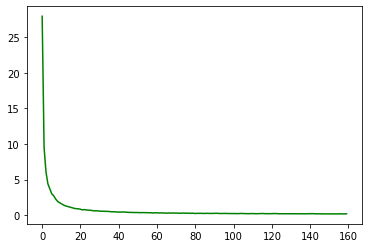

TRAINING TIME = 140.9547233581543



In [49]:
from sklearn.utils import shuffle

start_time = time.time()

losses = []

losses_test = []
test_data = losses_per_image_test
test_labels = tf.one_hot(y_test, 10)

epochs = 100

for j in range(epochs):
  new_losses_per_image_train, new_y_train = shuffle(new_losses_per_image_train, new_y_train)

  for i in range(16):
    dataset1 = setup_dataset_no_shuffle(new_losses_per_image_train[1000*i:1000*(i+1)], tf.one_hot(new_y_train[1000*i:1000*(i+1)],10))
    loss = train_only_dataset(model, dataset1, 1)
    losses = np.append(losses, loss.numpy())

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

In [0]:
predicted_class_4 = np.argmax(model(losses_per_image_test), axis=1)

#### Check accuracy of results

**Function to determine the accuracy given the predictions**

In [0]:
def compute_accuracy(predictions, y):
  predictions = predictions.astype('int')
  y = y.astype('int')

  wrong_guesses = []
  table_of_counts = np.zeros([N_class+1, N_class+1])
  for i in range(len(predictions)):
    table_of_counts[y[i], predictions[i]]+=1
    if y[i] != predictions[i]:
        wrong_guesses.append(i)
  
  for i in range(N_class):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')
  for i in range(N_class):
    table_of_counts[-1,i] = np.sum(table_of_counts[0:10,i])-table_of_counts[i,i]

  index = list(str('-') * (N_class+1))
  columns = list(str('-') * (N_class+1))
  for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
  index[-1] = 'False Positives'
  columns[-1] = 'Percentage'
  table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

  accuracy = 100*table_of_counts.trace()/np.sum(table_of_counts[0:10,0:10])
  average_accuracy = np.sum(table['Percentage'])/10

  return table, accuracy, average_accuracy, wrong_guesses

**Calculate the accuracies for each method**

In [53]:
table_1, accuracy_1, average_accuracy_1, wrong_guesses_1 = compute_accuracy(predicted_class_1, y_test)
print('WACC (%) = {}'.format(average_accuracy_1))
print('ACC (%)  = {}%'.format(accuracy_1))
table_1

WACC (%) = 63.0995361328125
ACC (%)  = 63.1%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,3.0,0.0,0.0,6.0,0.0,0.0,957.0,0.0,34.0,0.0,0.300049
Class 1,0.0,747.0,0.0,74.0,6.0,0.0,157.0,0.0,16.0,0.0,74.687500
Class 2,0.0,0.0,51.0,0.0,165.0,0.0,764.0,0.0,20.0,0.0,5.101562
Class 3,4.0,0.0,0.0,470.0,75.0,0.0,400.0,0.0,50.0,1.0,47.000000
Class 4,0.0,0.0,5.0,6.0,466.0,0.0,512.0,0.0,11.0,0.0,46.593750
Class 5,0.0,0.0,0.0,0.0,0.0,783.0,1.0,131.0,4.0,81.0,78.312500
Class 6,0.0,0.0,4.0,3.0,36.0,0.0,924.0,0.0,33.0,0.0,92.375000
Class 7,0.0,0.0,0.0,0.0,0.0,7.0,0.0,925.0,1.0,67.0,92.500000
Class 8,0.0,0.0,0.0,0.0,0.0,0.0,14.0,2.0,983.0,1.0,98.312500
Class 9,0.0,0.0,0.0,0.0,0.0,2.0,1.0,39.0,0.0,958.0,95.812500


In [54]:
table_2, accuracy_2, average_accuracy_2, wrong_guesses_2 = compute_accuracy(predicted_class_2, y_test)
print('WACC (%) = {}'.format(average_accuracy_2))
print('ACC (%)  = {}%'.format(accuracy_2))
table_2

WACC (%) = 70.228125
ACC (%)  = 70.23%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,645.0,23.0,24.0,33.0,1.0,0.0,269.0,0.0,5.0,0.0,64.50000
Class 1,59.0,873.0,10.0,34.0,3.0,0.0,21.0,0.0,0.0,0.0,87.31250
Class 2,66.0,6.0,655.0,20.0,80.0,0.0,172.0,0.0,1.0,0.0,65.50000
Class 3,310.0,38.0,16.0,558.0,14.0,0.0,62.0,0.0,2.0,0.0,55.81250
Class 4,28.0,8.0,356.0,79.0,362.0,0.0,166.0,0.0,1.0,0.0,36.18750
Class 5,16.0,3.0,0.0,0.0,0.0,923.0,3.0,28.0,9.0,18.0,92.31250
Class 6,219.0,7.0,342.0,35.0,34.0,0.0,356.0,0.0,7.0,0.0,35.59375
Class 7,0.0,0.0,0.0,0.0,0.0,130.0,0.0,794.0,3.0,73.0,79.37500
Class 8,32.0,10.0,23.0,5.0,0.0,1.0,14.0,0.0,914.0,1.0,91.37500
Class 9,4.0,0.0,0.0,0.0,0.0,25.0,2.0,26.0,0.0,943.0,94.31250


In [55]:
table_3, accuracy_3, average_accuracy_3, wrong_guesses_3 = compute_accuracy(predicted_class_3, y_test)
print('WACC (%) = {}'.format(average_accuracy_3))
print('ACC (%)  = {}%'.format(accuracy_3))
table_3

WACC (%) = 67.959375
ACC (%)  = 67.96%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,166.0,0.0,66.0,76.0,54.0,2.0,615.0,0.0,21.0,0.0,16.59375
Class 1,4.0,672.0,8.0,207.0,33.0,1.0,67.0,0.0,8.0,0.0,67.18750
Class 2,0.0,0.0,556.0,15.0,346.0,1.0,77.0,0.0,5.0,0.0,55.59375
Class 3,1.0,3.0,27.0,746.0,115.0,1.0,96.0,0.0,11.0,0.0,74.62500
Class 4,0.0,0.0,187.0,51.0,728.0,0.0,29.0,0.0,5.0,0.0,72.81250
Class 5,0.0,0.0,0.0,1.0,0.0,851.0,2.0,86.0,4.0,56.0,85.12500
Class 6,11.0,0.0,278.0,53.0,296.0,0.0,346.0,0.0,16.0,0.0,34.59375
Class 7,0.0,0.0,0.0,0.0,0.0,33.0,0.0,874.0,0.0,93.0,87.37500
Class 8,0.0,0.0,26.0,5.0,10.0,9.0,22.0,8.0,917.0,3.0,91.68750
Class 9,0.0,0.0,0.0,0.0,3.0,11.0,1.0,44.0,1.0,940.0,94.00000


In [56]:
table_4, accuracy_4, average_accuracy_4, wrong_guesses_4 = compute_accuracy(predicted_class_4, y_test)
print('WACC (%) = {}'.format(average_accuracy_4))
print('ACC (%)  = {}%'.format(accuracy_4))
table_4

WACC (%) = 67.78359375
ACC (%)  = 67.78%


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,109.0,0.0,4.0,75.0,16.0,0.0,768.0,1.0,27.0,0.0,10.898438
Class 1,3.0,643.0,3.0,233.0,29.0,1.0,85.0,0.0,3.0,0.0,64.312500
Class 2,0.0,0.0,286.0,18.0,344.0,0.0,344.0,0.0,8.0,0.0,28.593750
Class 3,1.0,2.0,7.0,778.0,81.0,0.0,123.0,0.0,7.0,1.0,77.812500
Class 4,0.0,0.0,60.0,68.0,736.0,0.0,133.0,0.0,3.0,0.0,73.625000
Class 5,0.0,0.0,0.0,1.0,0.0,856.0,0.0,101.0,1.0,41.0,85.625000
Class 6,8.0,0.0,60.0,60.0,260.0,0.0,586.0,0.0,25.0,1.0,58.593750
Class 7,0.0,0.0,0.0,0.0,0.0,21.0,0.0,918.0,1.0,60.0,91.812500
Class 8,0.0,0.0,2.0,9.0,12.0,1.0,31.0,5.0,937.0,3.0,93.687500
Class 9,0.0,0.0,0.0,0.0,0.0,7.0,1.0,63.0,0.0,929.0,92.875000
